# Calibrating machine-learning models to increase the prediction accuracy of specific experiments
### Aleš Křenek
#### Sitola, 22.9.2021

In [63]:
trainf='train_positive.tsv'
featf='features_pos.csv'

import pandas as pd
import pickle
import matplotlib.pyplot as plt
import numpy as np
from os import getcwd,chdir

from moldescriptors import get_features
from main import make_preds

datadir='/data'
prefix='/opt/callc/rt/'
modlib=prefix + 'mods_l1/'
#models=['adaboost','bayesianregr','lasso']
models=['bayesianregr','lasso']

featn=[x.strip() for x in open(prefix+"features/selected_features.txt").readlines()]
featn.remove('system')

## Train a fresh model with our data

In [61]:
from sklearn.linear_model import ARDRegression
from scipy.stats import randint
from scipy.stats import uniform

model = ARDRegression()
params = {
        "n_iter" : randint(100,1500),
        "alpha_1" : uniform(1e-10,1e-2),
        "lambda_1" : uniform(1e-10,1e-2),
        "threshold_lambda" : randint(1,10000),
    }


In [62]:
trainpos = pd.read_csv(trainf,sep='\t')
with open('feats_lib.csv','w'): pass
get_features(infile_name=trainf,outfile_name=featf,id_index=3,mol_index=0,time_index=2)
features = pd.read_csv(featf)[featn]
features.shape

(175, 159)

In [4]:
features[:5]

,IDENTIFIER,time,fr_C_O_noCOO,PEOE_VSA3,Chi4v,fr_Ar_COO,fr_SH,Chi4n,SMR_VSA10,fr_para_hydroxylation,...,fr_phenol,MolMR,PEOE_VSA9,fr_aldehyde,fr_pyridine,fr_tetrazole,fr_nitro_arom_nonortho,Chi0v,NumRotatableBonds,MaxAbsPartialCharge
0,1,876.6,2,18.559346,3.293558,0,0,2.524424,52.428500,0,...,0,113.6279,15.608718,0,1,0,0,18.504913,4,0.434389
1,2,921.6,0,0.000000,11.278710,0,0,11.278710,5.969305,0,...,0,188.7364,72.558621,0,0,0,0,32.838949,9,0.480963
2,3,162.6,0,0.000000,0.554594,0,0,0.381411,23.497618,0,...,0,33.6618,0.000000,0,0,0,0,5.130235,0,0.367607
3,4,227.4,0,4.565048,1.783489,0,1,0.363556,19.046256,0,...,0,39.8445,13.213764,0,0,0,0,7.322240,4,0.385581
4,5,621.0,1,0.000000,1.471488,0,0,1.471488,5.907180,0,...,0,58.4305,0.000000,0,0,0,0,9.079077,3,0.339206


In [64]:
from random import shuffle
testsize=int(len(features.index)*.2)
index=list(range(len(features.index)))
shuffle(index)
test=features.iloc[index[:testsize]]
train=features.iloc[index[testsize:]]

In [65]:
from sklearn.model_selection import KFold
from trainl1 import train_model_l1
cv = list(KFold(n_splits=10,shuffle=True).split(train.index))
# cv = None #XXX
model,preds = train_model_l1(train.drop(["time","IDENTIFIER","system"],axis=1, errors="ignore"),
                                             train["time"],params,model,
                                             cv = cv,n_params=20,
                                             n_jobs=4)

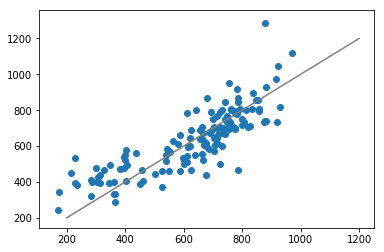

In [104]:
plt.plot([200,1200],[200,1200],color='grey')
plt.scatter(train['time'],preds)
plt.show()

In [102]:
test_preds = pd.DataFrame(model.predict(test.drop(["time","IDENTIFIER"],axis=1)),index=test.index,columns=['predictions'])


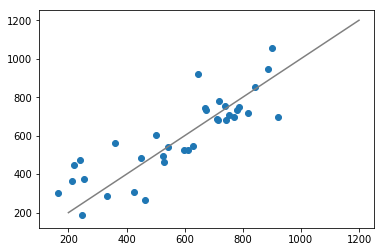

In [105]:
plt.plot([200,1200],[200,1200],color='grey')
plt.scatter(test['time'],test_preds)
plt.show()

## Apply available models on our data

In [28]:
def apply_model(X,modname):
    modf=modlib + modname + '42.pickle'
    print('opening ',modf)
    with open(modf,"rb") as m:
        model = pickle.load(m,encoding='latin1')
    preds=model.predict(X)
    return preds

In [29]:
dataset='MTBLS20'
preds={}
for m in models:
    preds[m] = apply_model(features.drop(['IDENTIFIER','time'],axis=1),modname=dataset+'_'+m)

opening  /opt/callc/rt/mods_l1/MTBLS20_bayesianregr42.pickle
opening  /opt/callc/rt/mods_l1/MTBLS20_lasso42.pickle


/opt/conda/envs/callc/lib/python3.6/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator ARDRegression from version pre-0.18 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/opt/conda/envs/callc/lib/python3.6/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator Lasso from version pre-0.18 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


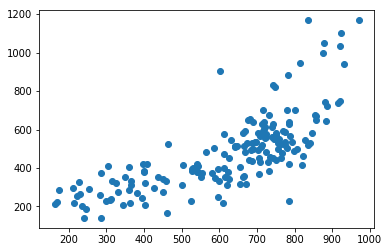

In [45]:
bayes_good=(preds['bayesianregr'] < 1200)
plt.scatter(np.array(features['time'])[bayes_good],preds['bayesianregr'][bayes_good])

In [43]:
lasso_good=(np.abs(preds['lasso']) < 1000)

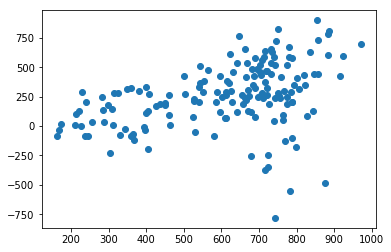

In [47]:
lasso_good=(np.abs(preds['lasso']) < 1000)
plt.scatter(np.array(features['time'])[lasso_good],preds['lasso'][lasso_good])

## Employ the big beast

In [69]:
chdir(datadir)
train.to_csv('reference.csv')
test.to_csv('test.csv')
chdir(prefix)
make_preds(reference_infile=datadir + '/reference.csv',pred_infile=datadir + '/test.csv',
           outfile=datadir+'/test_preds')

Total number of train molecules with tR: 140
Training Layer 1 LASSO


/opt/conda/envs/callc/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Training Layer 1 AdaBoost
Training Layer 1 XGBoost
Training Layer 1 SVR
Training Layer 1 BRR
Applying model: mods_l1/FEM_orbitrap_urine_adaboost42.pickle
Unable to load: <_io.BufferedReader name='mods_l1/FEM_orbitrap_urine_adaboost42.pickle'>
Could not execute: mods_l1/FEM_orbitrap_urine_adaboost42.pickle local variable 'model' referenced before assignment
Applying model: mods_l1/PFR-TK72_bayesianregr42.pickle
Applying model: mods_l1/FEM_orbitrap_plasma_SVM42.pickle
Applying model: mods_l1/1290SQ_lasso42.pickle
Applying model: mods_l1/MPI_Symmetry_lasso42.pickle
Applying model: mods_l1/MTBLS19_bayesianregr42.pickle
Applying model: mods_l1/MTBLS87_SVM42.pickle
Applying model: mods_l1/MTBLS36_lasso42.pickle
Applying model: mods_l1/MTBLS17_lasso42.pickle
Applying model: mods_l1/MTBLS20_lasso42.pickle
Applying model: mods_l1/Ken_lasso42.pickle
Applying model: mods_l1/Krauss_adaboost42.pickle
Unable to load: <_io.BufferedReader name='mods_l1/Krauss_adaboost42.pickle'>
Applying model: mods_l

/opt/conda/envs/callc/lib/python3.6/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator ARDRegression from version pre-0.18 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/opt/conda/envs/callc/lib/python3.6/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator SVR from version pre-0.18 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/opt/conda/envs/callc/lib/python3.6/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator Lasso from version pre-0.18 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/opt/conda/envs/callc/lib/python3.6/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator Lasso from version pre-0.18 when using version 0.20.0. This might lead to breaking code or invalid results.

Applying model: mods_l1/Ken_SVM42.pickle
Applying model: mods_l1/MTBLS20_bayesianregr42.pickle
Applying model: mods_l1/Eawag_XBridgeC18_adaboost42.pickle
Unable to load: <_io.BufferedReader name='mods_l1/Eawag_XBridgeC18_adaboost42.pickle'>
Applying model: mods_l1/MTBLS20_adaboost42.pickle
Unable to load: <_io.BufferedReader name='mods_l1/MTBLS20_adaboost42.pickle'>
Applying model: mods_l1/Vogler_bayesianregr42.pickle
Applying model: mods_l1/MTBLS17_adaboost42.pickle
Unable to load: <_io.BufferedReader name='mods_l1/MTBLS17_adaboost42.pickle'>
Applying model: mods_l1/MTBLS36_adaboost42.pickle
Unable to load: <_io.BufferedReader name='mods_l1/MTBLS36_adaboost42.pickle'>
Applying model: mods_l1/Mark_lasso42.pickle
Applying model: mods_l1/Cao_HILIC_adaboost42.pickle
Unable to load: <_io.BufferedReader name='mods_l1/Cao_HILIC_adaboost42.pickle'>
Applying model: mods_l1/Krauss_21_bayesianregr42.pickle
Applying model: mods_l1/IPB_Halle_SVM42.pickle
Applying model: mods_l1/MTBLS4_adaboost42.p

/opt/conda/envs/callc/lib/python3.6/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator ARDRegression from version pre-0.18 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/opt/conda/envs/callc/lib/python3.6/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator Lasso from version pre-0.18 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/opt/conda/envs/callc/lib/python3.6/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator ARDRegression from version pre-0.18 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/opt/conda/envs/callc/lib/python3.6/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator SVR from version pre-0.18 when using version 0.20.0. This might lead to breaking code or invalid 

Applying Layer 3...
Layer 3 fitted coefficient (c18pest_100_1_brr): 0.231
Layer 3 fitted coefficient (c18pest_60_1_xgb): 0.117
Layer 3 fitted coefficient (Toshimitsu_bayesianregr): 0.149
Layer 3 fitted coefficient (FEM_long_SV): 0.240
Layer 3 fitted coefficient (MASSTRPLAN_brr): 0.191
Layer 3 sum coefficients: 0.927
Done, predictions can be found here: /data/test_preds.csv


In [70]:
chdir(datadir)
big_pred=pd.read_csv('test_preds.csv')

In [95]:
eval_inhouse=pd.concat([test[['time']],pd.DataFrame(test_preds)],axis=1)
eval_inhouse

,time,0
0,NaN,718.488839
1,921.6,695.075873
2,162.6,548.689385
3,NaN,605.885670
4,NaN,708.008628
5,NaN,525.057924
6,NaN,850.757549
7,715.8,525.336994
8,NaN,264.473025
9,NaN,538.910934


In [94]:
test[['time']]

,time
106,819.0
1,921.6
164,630.0
150,501.0
131,751.2
51,612.0
12,842.4
71,596.4
39,463.2
105,543.0


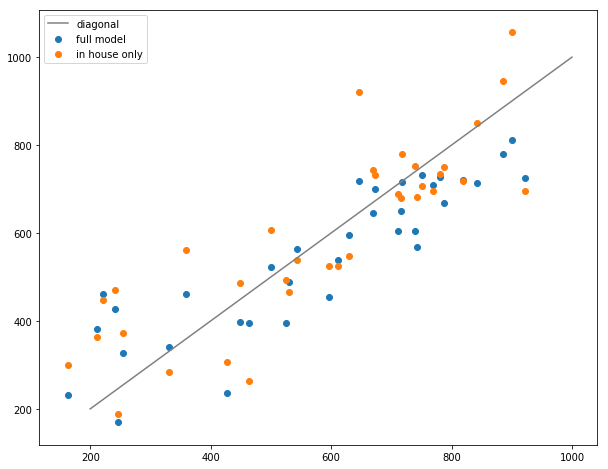

In [85]:
plt.figure(figsize=(10,8))
plt.plot([200,1000],[200,1000],label='diagonal',color='grey')
plt.scatter(test['time'],big_pred['predictions'],label='full model')
plt.scatter(test['time'],test_preds,label='in house only')
plt.legend()
plt.show()

,IDENTIFIER,time,fr_C_O_noCOO,PEOE_VSA3,Chi4v,fr_Ar_COO,fr_SH,Chi4n,SMR_VSA10,fr_para_hydroxylation,...,fr_phenol,MolMR,PEOE_VSA9,fr_aldehyde,fr_pyridine,fr_tetrazole,fr_nitro_arom_nonortho,Chi0v,NumRotatableBonds,MaxAbsPartialCharge
106,107,819.0,1,4.794537,3.337148,0,0,2.066660,28.648038,1,...,0,90.9380,11.415714,0,0,0,0,14.145842,2,0.331048
1,2,921.6,0,0.000000,11.278710,0,0,11.278710,5.969305,0,...,0,188.7364,72.558621,0,0,0,0,32.838949,9,0.480963
164,165,630.0,2,9.589074,1.694263,0,0,1.694263,23.561253,1,...,0,83.1754,6.606882,0,0,0,0,12.036252,4,0.449608
150,151,501.0,2,14.812362,2.271283,0,0,2.271283,17.687806,1,...,0,73.3320,12.232143,0,0,0,0,11.880792,4,0.446209
131,132,751.2,2,13.404969,2.727526,0,0,1.789570,41.002108,0,...,0,106.5610,13.027704,0,0,0,0,17.139302,9,0.465933
51,52,612.0,0,9.967957,1.432430,0,0,1.432430,11.635726,1,...,0,61.2307,0.000000,0,0,0,0,8.858529,2,0.324172
12,13,842.4,0,4.390415,2.464813,0,0,1.889015,34.104805,0,...,0,78.2370,15.925558,0,1,0,0,11.620015,2,0.456548
71,72,596.4,0,0.000000,1.363219,0,0,1.007708,23.658564,0,...,0,64.5304,0.000000,0,0,0,0,10.350843,5,0.354327
39,40,463.2,3,8.417797,3.095468,0,0,2.454526,32.874374,0,...,0,77.8917,15.382246,0,0,0,0,12.960418,4,0.298387
105,106,543.0,1,0.000000,1.738789,0,0,1.738789,11.594566,1,...,0,62.9577,12.179986,0,0,0,0,9.324568,2,0.497729
